# LIVRABLE 1 - Classification binaire (Projet LEYENDA)

Objectif : Distinguer les photos naturelles (couleur ou noir et blanc) des autres types d'images (peintures, textes, dessins, schémas...)


# Partie 1 : Initialisation & Vérification GPU

Cette partie initialise toutes les bibliothèques nécessaires au projet et vérifie la disponibilité du GPU.

In [ ]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

gpus = tf.config.list_physical_devices('GPU')
print("GPU disponible :", gpus)

# Partie 2 : Organisation Initiale des Images

Cette section sert à préparer le répertoire de travail pour l’entraînement du modèle. 
On copie les images sources dans un répertoire temporaire (images_work) afin de préserver les fichiers originaux.

Objectif : Créer une copie structurée du dossier ./images dans un dossier de travail ./images_work, avec une sous-structure par catégorie.

In [ ]:
source_dir = "./images"
working_dir = "./images_work"

categories = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]
os.makedirs(working_dir, exist_ok=True)

for category in categories:
    src_path = os.path.join(source_dir, category)
    dst_path = os.path.join(working_dir, category)

    if not os.path.exists(dst_path):
        shutil.copytree(src_path, dst_path)
        print(f"[COPIED] {category}")

# Partie 3 : Conversion en RGB & Redimensionnement des Images

Cette étape est essentielle pour uniformiser les images avant de les utiliser comme entrée dans le réseau de neurones.

Objectifs : Convertir toutes les images en format RGB, redimensionner toutes les images à 256x256 pixels, convertir en PNG

In [ ]:
for category in categories:
    path = os.path.join(working_dir, category)
    files = [f for f in os.listdir(path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

    for file in tqdm(files, desc=f"Traitement {category}"):
        img_path = os.path.join(path, file)
        img = Image.open(img_path).convert('RGB').resize((256, 256), Image.Resampling.LANCZOS)
        img.save(os.path.join(path, Path(file).stem + '.png'))

        if not file.endswith('.png'):
            os.remove(img_path)
    print(f"[CONVERTED] {category}")

# Partie 4 : Préparation du Dataset Binaire

Cette étape consiste à réorganiser les données d’entraînement pour entraîner un modèle de classification binaire : distinguer les photos des autres types d’images.

Objectif : Créer deux dossiers (photo et non_photo)

In [ ]:
binary_dir = os.path.join(working_dir, "binary_data")
photo_dir = os.path.join(binary_dir, "photo")
non_photo_dir = os.path.join(binary_dir, "non_photo")
os.makedirs(photo_dir, exist_ok=True)
os.makedirs(non_photo_dir, exist_ok=True)

for category in categories:
    src = os.path.join(working_dir, category)
    dst = photo_dir if category == "Photo" else non_photo_dir

    for file in os.listdir(src):

        shutil.copy(os.path.join(src, file), os.path.join(dst, f"{category}_{file}"))
    print(f"[COPIED] {category} images to {dst}")

# Partie 5 : Préparation du Dataset

Dans cette section, on prépare les données pour l’entraînement, ce qui permet de générer plus de diversité dans le dataset à partir d’un petit volume de données, réduire le risque d’overfitting, améliorer la robustesse du modèle

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

train_gen = train_datagen.flow_from_directory(
    binary_dir, target_size=(256,256), batch_size=25, class_mode='binary', subset='training')

val_gen = train_datagen.flow_from_directory(
    binary_dir, target_size=(256,256), batch_size=25, class_mode='binary', subset='validation')
print(f"[TRAINING] {len(train_gen)} batches")
print(f"[VALIDATION] {len(val_gen)} batches")

Found 33120 images belonging to 2 classes.
Found 8279 images belonging to 2 classes.
[TRAINING] 1325 batches
[VALIDATION] 332 batches


# Partie 6 : Modèle CNN Optimisé

Dans cette étape, on définit un modèle de réseau de neurones convolutifs (CNN) optimisé pour la classification binaire (photo / non-photo). Il inclut des techniques de régularisation (batch normalization, dropout, L2) pour améliorer la généralisation et limiter le surapprentissage.

In [ ]:
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(256,256,3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,840,001 (56.61 MB)

 Trainable params: 14,839,553 (56.61 MB)

 Non-trainable params: 448 (1.75 KB)

# Partie 7 : Entraînement et Validation du Modèle

Dans cette étape, le modèle CNN est entraîné sur le dataset binaire.

Objectifs : Lancer l’entraînement sur 25 Epoch, surveiller la perte de validation (val_loss) pour éviter l’overfitting, adapter dynamiquement le taux d’apprentissage si le modèle stagne, restaurer automatiquement les meilleurs poids du modèle si nécessaire

In [ ]:

callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

history = model.fit(train_gen, epochs=25, validation_data=val_gen, callbacks=callbacks)

Epoch 1/25
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 469s 353ms/step - accuracy: 0.7566 - loss: 105.2995 - val_accuracy: 0.4516 - val_loss: 15.1145 - learning_rate: 0.0010
Epoch 2/25
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 498s 376ms/step - accuracy: 0.7619 - loss: 6.6672 - val_accuracy: 0.3180 - val_loss: 3.8211 - learning_rate: 0.0010
Epoch 3/25
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 466s 351ms/step - accuracy: 0.7823 - loss: 1.5305 - val_accuracy: 0.5759 - val_loss: 1.0500 - learning_rate: 0.0010
Epoch 4/25
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 476s 359ms/step - accuracy: 0.7944 - loss: 0.9722 - val_accuracy: 0.5254 - val_loss: 3.0154 - learning_rate: 0.0010
Epoch 5/25
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 461s 348ms/step - accuracy: 0.7888 - loss: 1.3649 - val_accuracy: 0.6332 - val_loss: 1.0051 - learning_rate: 0.0010
Epoch 6/25
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 469s 353ms/step - accuracy: 0.8003 - loss: 1.1427 - val_accuracy: 0.7117 - val_loss: 0.8372 - learning_rate: 0.0010
Epoch 7/25
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 1516s 1

# Partie 8 : Évaluation du Modèle

Après l’entraînement, on évalue la performance du modèle à l’aide de graphiques d’apprentissage, d’un rapport de classification détaillé et d’une matrice de confusion.

Objectifs : Visualiser la progression de l’apprentissage (accuracy et loss), générer des prédictions sur les données de validation, evaluer les performances (précision, rappel, F1-score), visualiser les erreurs avec une matrice de confusion


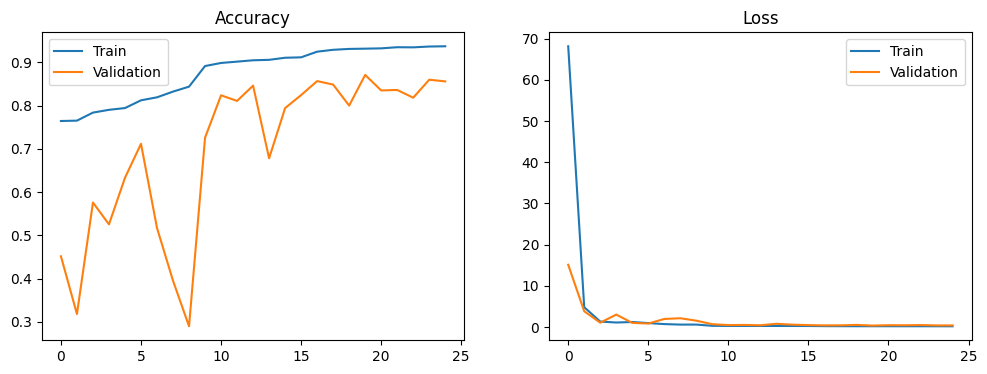

332/332 ━━━━━━━━━━━━━━━━━━━━ 48s 142ms/step
              precision    recall  f1-score   support

   non_photo       0.76      0.78      0.77      6281
       photo       0.24      0.21      0.23      1998

    accuracy                           0.65      8279
   macro avg       0.50      0.50      0.50      8279
weighted avg       0.63      0.65      0.64      8279



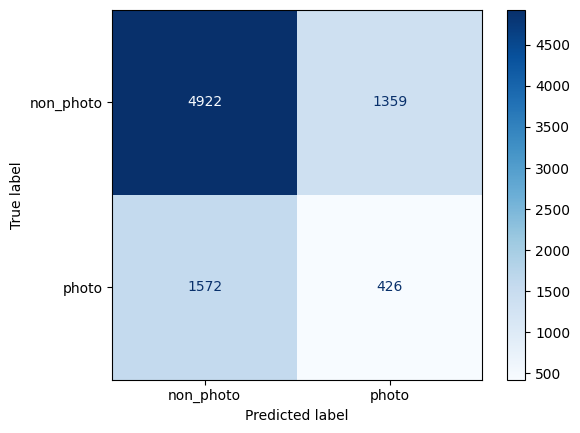

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.title('Loss')
plt.show()

val_labels = val_gen.classes
preds = model.predict(val_gen)
pred_classes = (preds > 0.5).astype("int32")

print(classification_report(val_labels, pred_classes, target_names=['non_photo','photo']))
ConfusionMatrixDisplay(confusion_matrix(val_labels, pred_classes), display_labels=['non_photo','photo']).plot(cmap='Blues')
plt.show()

# Partie 9 : Sauvegarde du Modèle

Une fois l’entraînement terminé et l’évaluation réalisée, il est important de sauvegarder le modèle pour pouvoir le réutiliser sans devoir le réentraîner à chaque fois.

Objectif : Sauvegarder l’architecture, les poids et l’état de compilation du modèle dans un seul fichier .h5

In [ ]:
model.save('binary_classifier.h5')
print("[MODEL SAVED] binary_classifier.h5")

[MODEL SAVED] binary_classifier.h5


# Partie 10 : Chargement du Modèle et Prédiction sur une Image

Cette partie permet d’utiliser le modèle entraîné et sauvegardé (binary_classifier.h5) pour effectuer une prédiction sur une image extérieure.

Objectifs : Recharger le modèle depuis le fichier .h5, prétraiter une image isolée (resize, normalisation), lancer une prédiction et afficher la classe : “Photo” ou “Non Photo”

In [ ]:
def load_model_and_predict(image_path):
    model = tf.keras.models.load_model('binary_classifier.h5')
    img = Image.open(image_path).convert('RGB').resize((256, 256), Image.Resampling.LANCZOS)
    img_array = np.expand_dims(np.array(img) / 255.0, axis=0)

    prediction = model.predict(img_array)
    class_label = "Photo" if prediction[0][0] > 0.5 else "Non Photo"
    print(f"[PREDICTION] {class_label}")

# Partie 11 : Test de Prédiction en Lot (Batch)

Cette partie permet de tester automatiquement un ensemble d’images depuis un répertoire donné en utilisant le modèle entraîné et sauvegardé. Chaque image est affichée avec sa prédiction associée.

Objectifs : Afficher l’image ainsi que la classe prédite : Photo ou Non Photo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
[PREDICTION] Non Photo
[TESTED] 4.png


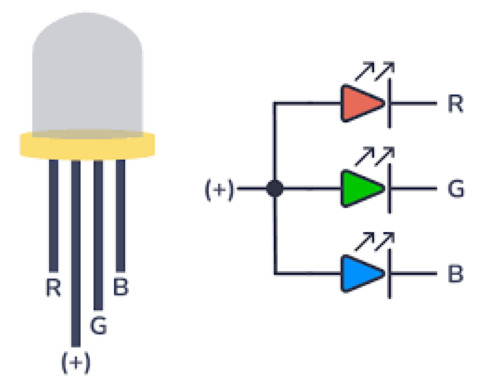

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
[PREDICTION] Photo
[TESTED] 5.png


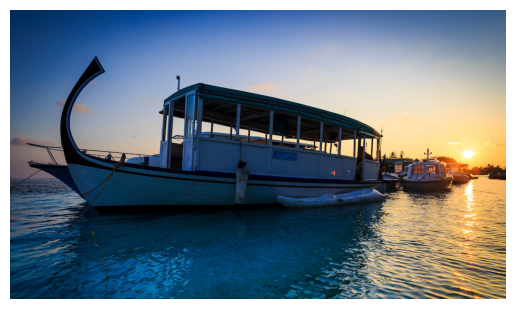

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
[PREDICTION] Non Photo
[TESTED] 2.png


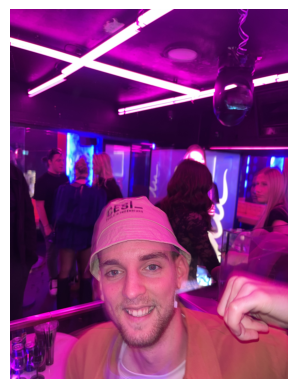

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
[PREDICTION] Non Photo
[TESTED] 3.png


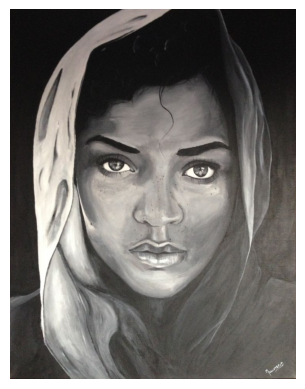

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
[PREDICTION] Non Photo
[TESTED] 1.png


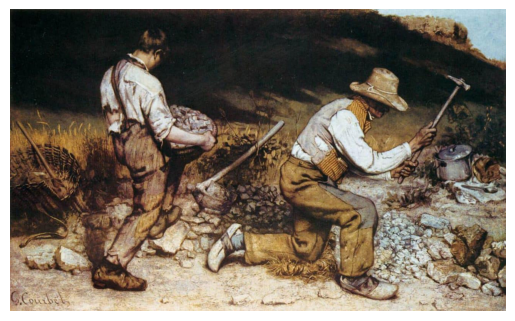

In [ ]:
for img in os.listdir('./dd/'):
    if img.endswith('.png'):
        load_model_and_predict(os.path.join('./dd/', img))
        print(f"[TESTED] {img}")
        # Afficher l'image
        img_path = os.path.join('./dd/', img)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()